In [1]:
import numpy as np
import pandas as pd


from scipy.stats import norm
from scipy.io import loadmat

from scipy.optimize import leastsq
from scipy.optimize import least_squares
from scipy.io import loadmat
from scipy.interpolate import interp1d
from scipy.stats import norm
import multiprocessing as mp
from scipy.fft import fft, ifft, fftshift,ifftshift
from scipy.signal import fftconvolve

import matplotlib

from scipy.signal import sosfilt, butter

font = {'size'   : 12}

matplotlib.rc('font', **font)

In [2]:
import matplotlib.pyplot as plt
%matplotlib widget

In [3]:
from vagusNerve.utils import *
from vagusNerve.runSim import *
from vagusNerve.phiShape import *
from vagusNerve.phiWeight import *
from vagusNerve.nerveSetup import *
from vagusNerve.recruitment import *

# Setup

In [4]:
time = getTime()
currents = np.arange(100,510,100) # Stimulus amplitudes
tIndex = np.intersect1d(np.where(time*1e3>2),np.where(time*1e3<7))

d = getDiameters() 
d1 = np.linspace(0,20,2000)
d1 = d1[d1<20]
d2 = getDiameters()*1e6
d2 = d2[d2<1]

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2573552/ipykernel_203689/2412756824.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  tIndex = np.intersect1d(np.where(time*1e3>2),np.where(time*1e3<7))
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2573552/ipykernel_203689/2412756824.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  d2 = getDiameters()*1e6


# The following section prooduces Figure A1

## The next several cells calculates fiber velocities for exemplary diameters

### Myelinated

In [5]:
def getVelocitiesM(diameter,t1,t2,s1,s2):
    
    internodeDistance = 100 * diameter # in um
    
    numSections = s2-s1
    
    time = t2-t1 # in ms
    
    distance = (1 + internodeDistance) * numSections * 1e-6 # in m. Add 1 to account for node length
    
    v = distance / (time * 1e-3) # in m/s
    
    return v

In [7]:
v20 = getVelocitiesM(20,1.005,1.2275,42,52)
v10 = getVelocitiesM(10,0.9825,1.20625,42,52)
v5 = getVelocitiesM(5,0.9475,1.165,42,52)
v2 = getVelocitiesM(2,0.8725,1.0775,42,52)

diamsM = np.array([0,2,5,10,20])
vM = np.array([0,v2,v5,v10,v20])

### Unmyelinated

In [8]:
def getVelocitiesU(t1,t2,s1,s2):
    
    sectionLength = 50 # in um
    
    numSections = s2-s1
    
    time = t2-t1 # in ms
    
    distance = sectionLength * numSections * 1e-6 # in m
    
    v = distance / (time * 1e-3) # in m/s
    
    return v

In [17]:
vp8 = getVelocitiesU(10.1125,11.3,85,95)
vp4 = getVelocitiesU(14.755,16.5175,85,95)
vp2 = getVelocitiesU(22.387501,25.0625,85,95)
vp3 = getVelocitiesU(17.455,19.537498,85,95)
vp6 = getVelocitiesU(11.7975,13.1925,85,95)
vp5 = getVelocitiesU(13.02,14.5675,85,95)
vp7 = getVelocitiesU(10.86,12.1425,85,95)

diamsU = np.array([0,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
vU = np.array([0,vp2,vp3,vp4,vp5,vp6,vp7,vp8])

## The next several cells fit the AP shape for exemplary diameters

### Myelinated

In [10]:
ap = pd.read_excel('/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/APShape20.xlsx') # Rat, 20 um

ap2 = pd.read_excel('/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/APShape10.xlsx') # Rat, 10 um

fitap = FitAPShape(ap,time)
fitap2 = FitAPShape(ap2,time)


### Unmyelinated

In [11]:
apU = pd.read_excel('/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/APShapePoint8.xlsx') # Sundt, 0.8 um

apU2 = pd.read_excel('/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/APShapePoint4.xlsx') # Sundt, 0.4 um

fitapU = FitAPShape(apU,time)
fitapU2 = FitAPShape(apU2,time)


## The next few cells load the stimuluation thresholds for several diameters

### Myelinated

In [12]:
thresholds = np.array([7.8125,3.2125,2.1875,1.60938,1.41406,1.22656,1.13281,0.9375,0.960938])
diameters = np.array([1,2,3,4,5,6,7,8,9])

thresholds *= 173


### Unmyelinated

In [13]:
thresholdsU = np.array([532,276,186,141,114,96,83,73,65.5])
diametersU = np.array([1,2,3,4,5,6,7,8,9])*0.1

thresholdsU *= 173


## Plots Figure A1

/nvme/tharayil/2567324/ipykernel_18777/2957988035.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(d1,86.95*d1/20)
/nvme/tharayil/2567324/ipykernel_18777/2957988035.py:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(d2,0.416*np.sqrt(d2/0.8))
/nvme/tharayil/2567324/ipykernel_18777/2957988035.py:28: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(time*1e3, fitap*1e3)
/nvme/tharayil/2567324/ipykernel_18777/2957988035.py:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(time*1e3, fitap2*1e3)
/nvme/tharayil/2567324/ipykernel_18777/2957988035.py:40: DeprecationWarning: __array_wrap__ must acc

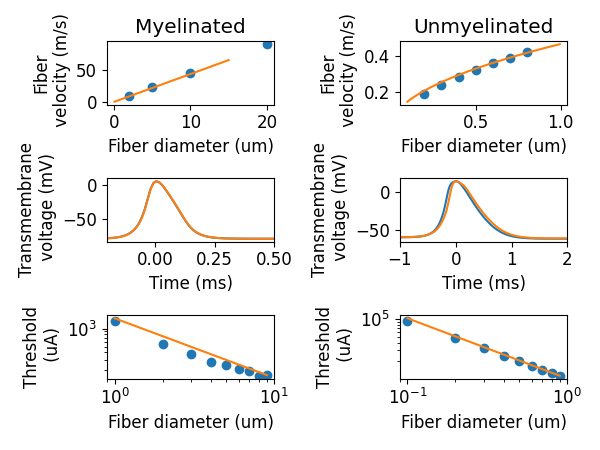

In [21]:
plt.figure(figsize=(6,4.5))

plt.subplot(3,2,1) # velocity, myelinated

plt.title('Myelinated')

plt.plot(diamsM[1:],vM[1:],'o')
plt.plot(d1,86.95*d1/20)
plt.xlabel('Fiber diameter (um)')
plt.ylabel('Fiber\n velocity (m/s)')

plt.tight_layout()

plt.subplot(3,2,2) # Velocity, unmyelinated

plt.title('Unmyelinated')

plt.plot(diamsU[1:],vU[1:],'o')
plt.plot(d2,0.416*np.sqrt(d2/0.8))
plt.xlabel('Fiber diameter (um)')
plt.ylabel('Fiber\n velocity (m/s)')


plt.tight_layout()

plt.subplot(3,2,3) # AP shape, myelinated

plt.plot(time*1e3, fitap*1e3)
plt.plot(time*1e3, fitap2*1e3)

plt.xlabel('Time (ms)')
plt.ylabel('Transmembrane\n voltage (mV)')

plt.xlim([-.2,.5])

plt.tight_layout()

plt.subplot(3,2,4) # AP shape, unmyelinated

plt.plot(time*1e3, fitapU*1e3)
plt.plot(time*1e3, fitapU2*1e3)

plt.xlabel('Time (ms)')
plt.ylabel('Transmembrane\n voltage (mV)')

plt.xlim([-1,2])

plt.tight_layout()

plt.subplot(3,2,5) # Threshold, myelinated

plt.loglog(diameters,thresholds,'o')
plt.loglog(diameters,thresholds[-1]*diameters[-1]/diameters)

plt.xlabel('Fiber diameter (um)')
plt.ylabel('Threshold\n (uA)')

plt.tight_layout()

plt.subplot(3,2,6) # Threshold, unmyelinated

plt.loglog(diametersU,thresholdsU,'o')
plt.loglog(diametersU,thresholdsU[-1]*diametersU[-1]/diametersU)

plt.xlabel('Fiber diameter (um)')
plt.ylabel('Threshold\n (uA)')

plt.tight_layout()

plt.savefig('figures/dataFigure.png',dpi=600)


# Loads signals from default configuration

### Horizontal electrode, high perineuria conductivity, large separation between recording electrodes, 6 cm from stimulus to recording electrode

In [5]:
outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic'

distanceIdx = 0 # 6 cm

maffAll = np.load(outputfolder+'/maff/'+str(distanceIdx)+'/signals_0.npy')[np.newaxis]

for i in np.arange(1,39):
    maffAll = np.vstack((maffAll,np.load(outputfolder+'/maff/'+str(distanceIdx)+'/signals_'+str(i)+'.npy')[np.newaxis]))
    
meffAll = np.load(outputfolder+'/meff/'+str(distanceIdx)+'/signals_0.npy')[np.newaxis]

for i in np.arange(1,39):
    meffAll = np.vstack((meffAll,np.load(outputfolder+'/meff/'+str(distanceIdx)+'/signals_'+str(i)+'.npy')[np.newaxis]))

uaffAll = np.load(outputfolder+'/uaff/'+str(distanceIdx)+'/signals_0.npy')[np.newaxis]

for i in np.arange(1,39):
    uaffAll = np.vstack((uaffAll,np.load(outputfolder+'/uaff/'+str(distanceIdx)+'/signals_'+str(i)+'.npy')[np.newaxis]))

ueffAll = np.load(outputfolder+'/ueff/'+str(0)+'/signals_0.npy')[np.newaxis]

for i in np.arange(1,39):
    ueffAll = np.vstack((ueffAll,np.load(outputfolder+'/ueff/'+str(0)+'/signals_'+str(i)+'.npy')[np.newaxis]))

totalAll = maffAll + meffAll+ uaffAll + ueffAll



In [6]:
signals = np.sum(totalAll,axis=0)

In [7]:
recruitment = []
for i in range(39):
    recruitment.append(np.load(outputfolder+'/recruitment/recruitment_'+str(i)+'.npy',allow_pickle=True))
    

# This next cell produces Figure 1, comparing in silico and in vivo recordings

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2573552/ipykernel_203689/1411868978.py:72: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax1.plot(time[1:-1][tIndex2:]*1e3,total6cm[i][tIndex2:],c=colorSet[i])
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2573552/ipykernel_203689/1411868978.py:119: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax5.plot(time[1:-1]*1e3,total1cm[i],c=colorSet[i])


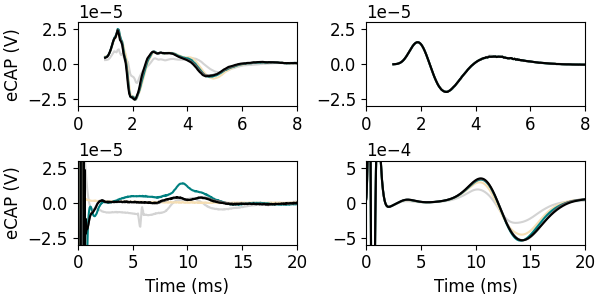

In [8]:
# 6 cm distance between stimulus and recording electrode
### Other parameters unchanged

from scipy.io import loadmat

colorSet = ['lightgray','wheat','teal','dimgray','black']

inVivoData = loadmat('/gpfs/bbp.cscs.ch/project/proj85/vagusNerve/vagusNerveCode/eCAPSdata_220303.mat')

a100 = list(inVivoData['eCAPSdata_220328'][0][-1])
a200 = list(inVivoData['eCAPSdata_220328'][0][-2])
a300 = list(inVivoData['eCAPSdata_220328'][0][-3])
a400 = list(inVivoData['eCAPSdata_220328'][0][-4])
a500 = list(inVivoData['eCAPSdata_220328'][0][-5])

tIndex1 = np.argmin(np.abs(a100[2][0]-1))
tIndex2 = np.argmin(np.abs(time[1:-1].magnitude*1e3-1))


outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_highAmp'

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(6,3),constrained_layout=True)

gs = GridSpec(2,2,figure=fig)

distanceIdx = 0

maff6cm = np.load(outputfolder+'/maff/'+str(distanceIdx)+'/signals.npy')
meff6cm = np.load(outputfolder+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff6cm = np.load(outputfolder+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff6cm = np.load(outputfolder+'/ueff/'+str(distanceIdx)+'/signals.npy') 


total6cm = maff6cm + meff6cm + uaff6cm + ueff6cm

legend = []

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])


ax4 = fig.add_subplot(gs[1,0])
ax5 = fig.add_subplot(gs[1,1])



ax0.ticklabel_format(style='sci',axis='y',scilimits=(0,0))

ax0.plot(a100[2][0][tIndex1:],a100[1][-1][tIndex1:]-a100[1][0][tIndex1:],c=colorSet[0])
ax0.plot(a100[2][0][tIndex1:],a200[1][-1][tIndex1:]-a200[1][0][tIndex1:],c=colorSet[1])
ax0.plot(a100[2][0][tIndex1:],a300[1][-1][tIndex1:]-a300[1][0][tIndex1:],c=colorSet[2])
ax0.plot(a100[2][0][tIndex1:],a400[1][-1][tIndex1:]-a400[1][0][tIndex1:],c=colorSet[3])
ax0.plot(a100[2][0][tIndex1:],a500[1][-1][tIndex1:]-a500[1][0][tIndex1:],c=colorSet[4])

# plt.xlabel('Time (ms)')
ax0.set_ylabel('eCAP (V)')

ax0.set_xlim([0,8])
ax0.set_ylim([-3e-5,3e-5])

outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_highAmp'


for i in np.arange(5):
    
    

    ax1.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
    
    ax1.plot(time[1:-1][tIndex2:]*1e3,total6cm[i][tIndex2:],c=colorSet[i])
    

ax1.set_xlim([0,8])
ax1.set_ylim([-3e-5,3e-5])

# 1 cm distance between stimulus and recording electrode
### Other parameters unchanged


distanceIdx = 1

maff1cm = np.load(outputfolder+'/maff/'+str(distanceIdx)+'/signals.npy')
meff1cm = np.load(outputfolder+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff1cm = np.load(outputfolder+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff1cm = np.load(outputfolder+'/ueff/'+str(distanceIdx)+'/signals.npy') 

inVivoData = loadmat('/gpfs/bbp.cscs.ch/project/proj85/vagusNerve/vagusNerveCode/eCAPSdata_220314.mat')

a100 = list(inVivoData['eCAPSdata_220314'][0][-1])
a200 = list(inVivoData['eCAPSdata_220314'][0][-2])
a300 = list(inVivoData['eCAPSdata_220314'][0][-3])
a400 = list(inVivoData['eCAPSdata_220314'][0][-4])
a500 = list(inVivoData['eCAPSdata_220314'][0][-5])

ax4.ticklabel_format(style='sci',axis='y',scilimits=(0,0))

ax4.plot(a100[2][0],a100[1][-1]-a100[1][0],c=colorSet[0])
ax4.plot(a100[2][0],a200[1][-1]-a200[1][0],c=colorSet[1])
ax4.plot(a100[2][0],a300[1][-1]-a300[1][0],c=colorSet[2])
ax4.plot(a100[2][0],a400[1][-1]-a400[1][0],c=colorSet[3])
ax4.plot(a100[2][0],a500[1][-1]-a500[1][0],c=colorSet[4])

ax4.set_ylabel('eCAP (V)')

ax4.set_xlim([0,20])
ax4.set_ylim([-3e-5,3e-5])

ax4.set_xlabel('Time (ms)')


total1cm = maff1cm + meff1cm + uaff1cm + ueff1cm

for i in np.arange(5):
    
    ax5.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
    
    ax5.plot(time[1:-1]*1e3,total1cm[i],c=colorSet[i])
    
    ax5.set_xlim([0,20])
    

    ax5.set_ylim([-6e-4,6e-4])

    ax5.set_xlabel('Time (ms)')


plt.savefig('figures/recordingfig/invivoFig.png',dpi=600)

## The following cell produces Figure 1 again, but with the legend plotted

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2566689/ipykernel_62706/3322975080.py:41: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax1.plot(time[1:-1]*1e3,total6cm[i],c=colorSet[i])
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2566689/ipykernel_62706/3322975080.py:75: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax5.plot(time[1:-1]*1e3,total1cm[i],c=colorSet[i])


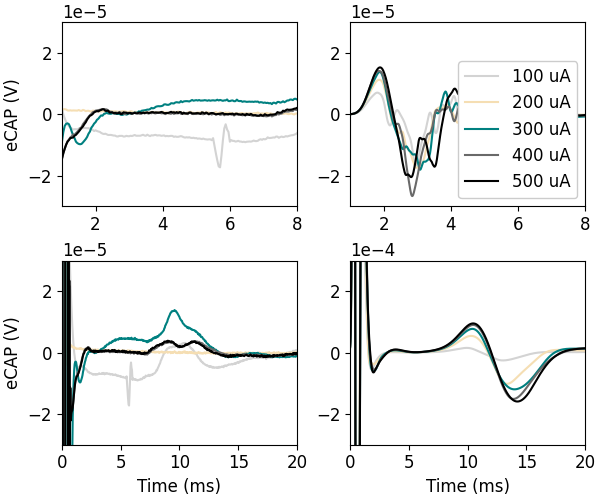

In [21]:
# 6 cm distance between stimulus and recording electrode
### Other parameters unchanged

fig = plt.figure(figsize=(6,5),constrained_layout=True)

gs = GridSpec(2,2,figure=fig)


legend = []

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])


ax4 = fig.add_subplot(gs[1,0])
ax5 = fig.add_subplot(gs[1,1])


ax0.ticklabel_format(style='sci',axis='y',scilimits=(0,0))

ax0.plot(a100[2][0],a100[1][-1]-a100[1][0],c=colorSet[0])
ax0.plot(a100[2][0],a200[1][-1]-a200[1][0],c=colorSet[1])
ax0.plot(a100[2][0],a300[1][-1]-a300[1][0],c=colorSet[2])
ax0.plot(a100[2][0],a400[1][-1]-a400[1][0],c=colorSet[3])
ax0.plot(a100[2][0],a500[1][-1]-a500[1][0],c=colorSet[4])

# plt.xlabel('Time (ms)')
ax0.set_ylabel('eCAP (V)')

ax0.set_xlim([1,8])
ax0.set_ylim([-3e-5,3e-5])



for i in np.arange(5):
    
    

    ax1.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
    
    ax1.plot(time[1:-1]*1e3,total6cm[i],c=colorSet[i])

    legend.append(str(np.round(currents[i]))+' uA')
    
ax1.legend(legend,loc='lower right',framealpha=1)
ax1.set_xlim([1,8])
ax1.set_ylim([-3e-5,3e-5])

# 1 cm distance between stimulus and recording electrode
### Other parameters unchanged


ax4.ticklabel_format(style='sci',axis='y',scilimits=(0,0))

ax4.plot(a100[2][0],a100[1][-1]-a100[1][0],c=colorSet[0])
ax4.plot(a100[2][0],a200[1][-1]-a200[1][0],c=colorSet[1])
ax4.plot(a100[2][0],a300[1][-1]-a300[1][0],c=colorSet[2])
ax4.plot(a100[2][0],a400[1][-1]-a400[1][0],c=colorSet[3])
ax4.plot(a100[2][0],a500[1][-1]-a500[1][0],c=colorSet[4])

ax4.set_ylabel('eCAP (V)')

ax4.set_xlim([0,20])
ax4.set_ylim([-3e-5,3e-5])

ax4.set_xlabel('Time (ms)')


total1cm = maff1cm + meff1cm + uaff1cm + ueff1cm

for i in np.arange(5):
    
    ax5.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
    
    ax5.plot(time[1:-1]*1e3,total1cm[i],c=colorSet[i])
    
    ax5.set_xlim([0,20])
    

    ax5.set_ylim([-3e-4,3e-4])

    ax5.set_xlabel('Time (ms)')


plt.savefig('figures/recordingfig/invivoFig_legend.png',dpi=600)

# The next cells produce the panels in Figure 2, showing how the eCAP is calculated for several exemplary fascicles

In [22]:
### Loads the diameter distributions for the fibers in each fascicle

outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic'

dist = []
for i in range(39):
    numFibers = np.load(outputfolder+'/fascicles/fibers'+str(i)+'.npy',allow_pickle=True)
    dist.append(np.load(outputfolder+'/fascicles/probDist'+str(i)+'.npy',allow_pickle=True)*numFibers/2000)

In [23]:
dist[0].shape

(4, 2000)

In [24]:
velocityList = getVelocities(d) # Gets velocity for each diameter

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2566689/ipykernel_62706/3044758139.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax.plot(d*1e6,recruitment[i][-1][0],c='C'+str(j))
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2566689/ipykernel_62706/3044758139.py:28: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax1.plot(d*1e6,dist[i][0],c='C'+str(j))
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2566689/ipykernel_62706/3044758139.py:45: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax2.plot(d*1e6,scaling[0]/(time[1]-time[0]),c='C'+str(j))
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2566689/ipykernel_62706/3044758139.py:60: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in t

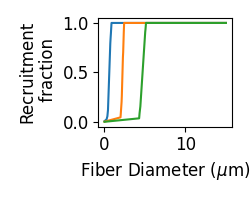

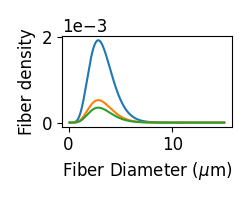

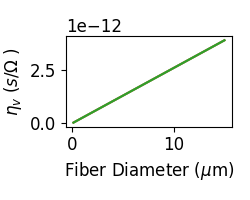

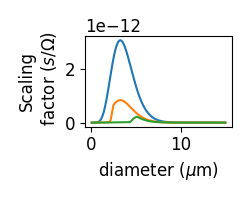

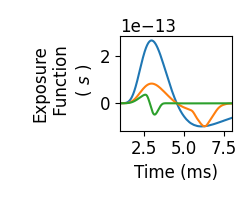

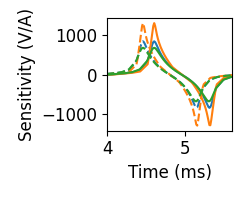

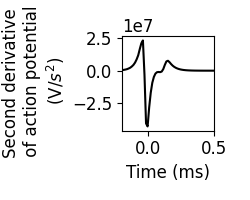

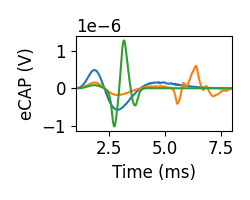

In [25]:
from matplotlib.gridspec import GridSpec

selections = [0,17,15]

outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic'

plt.figure(figsize=(2.5,2))

for j, i in enumerate(selections):

    ax = plt.gca()
    
    ax.plot(d*1e6,recruitment[i][-1][0],c='C'+str(j))

ax.set_xlabel('Fiber Diameter ($\mu$m)')
ax.set_ylabel('Recruitment\n fraction')

plt.tight_layout()

plt.savefig('figures/example/recruitment.png',dpi=600)

plt.figure(figsize=(2.5,2))

for j, i in enumerate(selections):
    
    ax1 = plt.gca() 

    ax1.plot(d*1e6,dist[i][0],c='C'+str(j))

ax1.ticklabel_format(axis='y',scilimits=[0,0])
ax1.set_xlabel('Fiber Diameter ($\mu$m)')
ax1.set_ylabel('Fiber density')
plt.tight_layout()

plt.savefig('figures/example/probability.png',dpi=600)

plt.figure(figsize=(2.5,2))

for j, i in enumerate(selections):

    ax2 = plt.gca()

    scaling = np.load(outputfolder+'/diameters/scaling_'+str(i)+'.npy')

    ax2.plot(d*1e6,scaling[0]/(time[1]-time[0]),c='C'+str(j))

ax2.set_xlabel('Fiber Diameter ($\mu$m)')
ax2.set_ylabel('$\eta_v$ ($ s / \Omega$ )')
plt.tight_layout()
plt.savefig('figures/example/currentscaling.png',dpi=600)

plt.figure(figsize=(2.5,2))

for j, i in enumerate(selections):

    ax3 = plt.gca()

    scaling = np.load(outputfolder+'/maff/scaling_'+str(i)+'.npy',allow_pickle=True)

    ax3.plot(d*1e6,scaling[:,-1]/(time[1]-time[0]),c='C'+str(j))

ax3.set_xlabel('diameter ($\mu$m)')
ax3.set_ylabel('Scaling\n factor ($ s / \Omega $)')
plt.tight_layout()

plt.savefig('figures/example/totalScaling.png',dpi=600)

plt.figure(figsize=(2.5,2))

for j, i in enumerate(selections):

    ax4 = plt.gca()

    phi = np.load(outputfolder+'/phis/0/'+str(i)+'.npy',allow_pickle=True)

    ax4.plot(time*1e3,phi[0,:,-1] / 509e-6,c='C'+str(j))
ax4.set_xlim([1,8])
ax4.set_xlabel('Time (ms)')
ax4.set_ylabel('Exposure\n Function\n ( $s$ )')

plt.tight_layout()

plt.savefig('figures/example/exposure.png',dpi=600)


plt.figure(figsize=(2.5,2))

for j, i in enumerate(selections):

    ax5 = plt.gca()

    femDirectory = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/PhiConductivity_Bipolar_Corrected/'

    phiFunc = FitPhiShape(i,0.06,femDirectory)# Defines an interpolation function for the recording exposure for the fasicle


    phiShape0 = PhiShape(velocityList[0],time,phiFunc)

    selectedDiameters = [3e-6,3.1e-6]*pq.m

    for idx, diam in enumerate(selectedDiameters):

        diamIdx = np.argmin(np.abs(d-diam))
        phi = phiShape0[diamIdx] / 509e-6

        if idx == 0:
            ax5.plot(time*1e3,phi,c='C'+str(j))
        else:
            ax5.plot(time*1e3,phi,'--',c='C'+str(j))


ax5.set_xlabel('Time (ms)')
ax5.set_ylabel('Sensitivity (V/A)')
ax5.set_xlim([4,5.6])

plt.tight_layout()

plt.savefig('figures/example/phi.png',dpi=600)


plt.figure(figsize=(2.5,2))

ax = plt.gca()

V = fitap

der = np.diff(V,n=2)/((time[1]-time[0])**2) # Second derivative of action potential shape

plt.plot(time[1:-1]*1e3,der,'k')
ax.set_xlabel('Time (ms)')
ax.set_xlim([-.2,.5])
ax.set_ylabel('Second derivative\n of action potential\n (V/$s^2$)')

plt.tight_layout()

plt.savefig('figures/example/derivative.png',dpi=600)

plt.figure(figsize=(2.5,2))

for j, i in enumerate(selections):
    
    plt.plot(time[1:-1]*1e3,maffAll[i,-1],c='C'+str(j))
    
plt.xlabel('Time (ms)')
plt.ylabel('eCAP (V)')
plt.xlim([1,8])

plt.tight_layout()

plt.savefig('figures/example/ecap.png',dpi=600)

# The following cells produce Figures 4a, d, and e, demonstrating correlations between eCAP contributions from different fascicles
## These cells also produce numpy files containing the rgb values of the fascicles in Figures 4 b and c.
### Same recording parameters are used as above
### Results shown are with 500 uA stimulus current

In [9]:
from sklearn.cluster import KMeans

In [10]:
normalizedSignals = totalAll[:,-1,tIndex] # Calculates correlations between fascicles on the potion of the signal between 1 and 7 ms
correlations = np.corrcoef(normalizedSignals)

In [11]:
# Clusters fascicles into 3 groups based on the correlations between the signals
nclusters = 3
model = KMeans(n_clusters=nclusters, random_state=0)
model.fit(correlations)

KMeans(n_clusters=3, random_state=0)

In [12]:
# Sorts the correlation matrix by cluster
fit_data = correlations[np.argsort(model.labels_)]
fit_data = fit_data[:, np.argsort(model.labels_)]

### Saves RGB values for each cluster in Figure 4b. The color bar associated with these RGB values is plotted along with Figure 7

In [13]:
rgbs = []

rgbList = [np.array([31,119,180])/255,np.array([255,127,14])/255,np.array([44,160,44])/255,np.array([214,39,40])/255]

for label in model.labels_:

    rgbs.append(rgbList[label])

np.save('figures/clusterRGB.npy',rgbs)

    

In [14]:
### Prints matrix rows for each cluster
s = np.sort(model.labels_)
for i in range(3):
    print(np.where(s==i))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),)
(array([27, 28, 29, 30, 31, 32, 33, 34, 35]),)
(array([36, 37, 38]),)


In [15]:
# Prints fascicles belonging to each cluster

print(np.argsort(model.labels_)[:27])
print(np.argsort(model.labels_)[27:35])
print(np.argsort(model.labels_)[35:])


[ 0  3  5  4  7 13 10  8 14 12 23 22 20 21 18 19 30 29 26 28 25 24 33 32
 35 34 36]
[27 17 16  9  1 11 37 38]
[31  6  2 15]


In [16]:
mean0 = np.mean(totalAll[model.labels_==0,-1],axis=0)
mean1 = np.mean(totalAll[model.labels_==1,-1],axis=0)
mean2 = np.mean(totalAll[model.labels_==2,-1],axis=0)

## Plots Figure 4 a, d, e

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2573552/ipykernel_203689/3706070030.py:18: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax1.plot(d*1e6,recruitment[i][-1][0],c='C'+str(model.labels_[i]))
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2573552/ipykernel_203689/3706070030.py:24: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax2.plot(time[1:-1]*1e3,totalAll[i,-1],c='C'+str(model.labels_[i]))


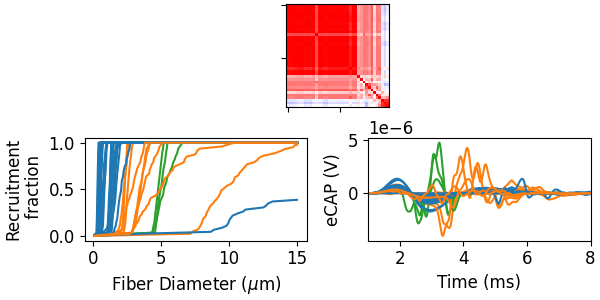

In [17]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(6,3),constrained_layout=True)

gs = GridSpec(2,2,figure=fig)

ax0 = fig.add_subplot(gs[0,:])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[1,1])

plot = ax0.imshow(fit_data, cmap=plt.cm.bwr,vmin=-1,vmax=1,interpolation='None')
ax0.set_xticklabels([])
ax0.set_yticklabels([])


for i in range(39):

    ax1.plot(d*1e6,recruitment[i][-1][0],c='C'+str(model.labels_[i]))
    
    ax1.set_xlabel('Fiber Diameter ($\mu$m)')
    ax1.set_ylabel('Recruitment\n fraction')
    
    
    ax2.plot(time[1:-1]*1e3,totalAll[i,-1],c='C'+str(model.labels_[i]))

    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('eCAP (V)')

    ax2.set_xlim([1,8])

plt.savefig('figures/correlations.png',dpi=600)

## Same as above, but with colorbar

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2566689/ipykernel_62706/2172083509.py:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax1.plot(d*1e6,recruitment[i][-1][0],c='C'+str(model.labels_[i]))
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2566689/ipykernel_62706/2172083509.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax2.plot(time[1:-1]*1e3,totalAll[i,-1],c='C'+str(model.labels_[i]))


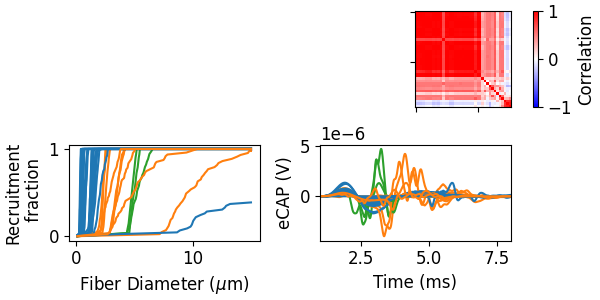

In [35]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(6,3),constrained_layout=True)

gs = GridSpec(2,2,figure=fig)

ax0 = fig.add_subplot(gs[0,:])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[1,1])

plot = ax0.imshow(fit_data, cmap=plt.cm.bwr,vmin=-1,vmax=1,interpolation='None')
ax0.set_xticklabels([])
ax0.set_yticklabels([])


fig.colorbar(plot, label='Correlation',location='right',fraction=0.05)


for i in range(39):

    ax1.plot(d*1e6,recruitment[i][-1][0],c='C'+str(model.labels_[i]))
    
    ax1.set_xlabel('Fiber Diameter ($\mu$m)')
    ax1.set_ylabel('Recruitment\n fraction')
    
    
    ax2.plot(time[1:-1]*1e3,totalAll[i,-1],c='C'+str(model.labels_[i]))

    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('eCAP (V)')

    ax2.set_xlim([1,8])
    

plt.savefig('figures/correlations_colorbar.png',dpi=600)

# The following cells produce Figure 5, demonstrating the relationship between stimulus current and eCAP amplitude

In [18]:
# Loads eCAP contributions from each fascicle

outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_lowCurrent_long'

distanceIdx = 0 # 6 cm

maffAll = np.load(outputfolder+'/maff/'+str(distanceIdx)+'/signals_0.npy')[np.newaxis]

for i in np.arange(1,39):
    maffAll = np.vstack((maffAll,np.load(outputfolder+'/maff/'+str(distanceIdx)+'/signals_'+str(i)+'.npy')[np.newaxis]))
    
meffAll = np.load(outputfolder+'/meff/'+str(distanceIdx)+'/signals_0.npy')[np.newaxis]

for i in np.arange(1,39):
    meffAll = np.vstack((meffAll,np.load(outputfolder+'/meff/'+str(distanceIdx)+'/signals_'+str(i)+'.npy')[np.newaxis]))

uaffAll = np.load(outputfolder+'/uaff/'+str(distanceIdx)+'/signals_0.npy')[np.newaxis]

for i in np.arange(1,39):
    uaffAll = np.vstack((uaffAll,np.load(outputfolder+'/uaff/'+str(distanceIdx)+'/signals_'+str(i)+'.npy')[np.newaxis]))

ueffAll = np.load(outputfolder+'/ueff/'+str(0)+'/signals_0.npy')[np.newaxis]

for i in np.arange(1,39):
    ueffAll = np.vstack((ueffAll,np.load(outputfolder+'/ueff/'+str(0)+'/signals_'+str(i)+'.npy')[np.newaxis]))

totalAll = maffAll + meffAll+ uaffAll + ueffAll

In [19]:
signalsLowCurrent = np.sum(totalAll,axis=0)

In [45]:
lowCurrents = np.arange(0,1600,100)/16 # Stimulus amplitudes

In [21]:
amplitudes = np.max(signalsLowCurrent[:,tIndex],axis=1)-np.min(signalsLowCurrent[:,tIndex],axis=1)

In [22]:
fascicleAmplitudes = np.max(totalAll[:,:,tIndex],axis=-1)-np.min(totalAll[:,:,tIndex],axis=-1)

In [23]:
# For each fascicle, calculates a color from the viridis color map, based on the location of the peak amplitude

amplitudePeaks = (np.argmax(fascicleAmplitudes,axis=-1)).astype(float)

amplitudePeaks /= 6

import matplotlib

cmap = matplotlib.cm.get_cmap('viridis')

rgbVals = cmap(amplitudePeaks)

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2573552/ipykernel_203689/703230580.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')


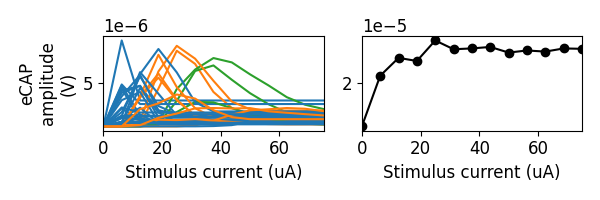

In [47]:
plt.figure(figsize=(6,2))

plt.subplot(1,2,1)

for i in range(39):
    
    amp = fascicleAmplitudes[i]
    
    plt.plot(lowCurrents,amp,c='C'+str(model.labels_[i]))

plt.xlim([0,1200/16])
plt.yticks([5e-6])
    
plt.xlabel('Stimulus current (uA)')
plt.ylabel('eCAP\namplitude\n(V)')

plt.subplot(1,2,2)

plt.plot(lowCurrents,amplitudes,'-o',c='k')

plt.xlabel('Stimulus current (uA)')

plt.xlim([0,1200/16])
plt.yticks([2e-5])

plt.tight_layout()

plt.savefig('figures/monotonicity.png',dpi=300)

In [25]:
recruitmentFractions = []
for fascIdx in np.arange(39):
    
    recruitment = np.load(outputfolder+'/recruitment/recruitment_'+str(fascIdx)+'.npy',allow_pickle=True)[:,0,:]
    probs = np.load(outputfolder+'/fascicles/probDist'+str(fascIdx)+'.npy',allow_pickle=True)
    pcts = np.load(outputfolder+'/fascicles/probs'+str(fascIdx)+'.npy',allow_pickle=True)

    
    maff = probs[0]/(pcts[0]+pcts[1])
    meff = probs[1]/(pcts[0]+pcts[1])

    frac = np.sum(maff*recruitment+meff*recruitment,axis=-1)

    recruitmentFractions.append(frac)

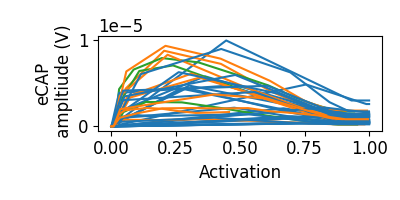

In [26]:
selectedFascicles = np.arange(39)
plt.figure(figsize=(4,2))
for f in selectedFascicles:
    plt.plot(recruitmentFractions[f],fascicleAmplitudes[f],c='C'+str(model.labels_[f]))

plt.xlabel('Activation')
plt.ylabel('eCAP\n ampltiude (V)') 
plt.tight_layout()
plt.savefig('figures/monotonicity_activation.png',dpi=300)

# The following cell produces Figure 6, showing the eCAPs from different recording electrode  configurations

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2573552/ipykernel_203689/605948425.py:34: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax0.plot(time[1:-1]*1e3,signals[-1],c='k')
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2573552/ipykernel_203689/605948425.py:36: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax0.plot(time[1:-1]*1e3,total3mm[-1],c='fuchsia')
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2573552/ipykernel_203689/605948425.py:70: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax7.plot(time[1:-1]*1e3,totalMonopolar[-1],':',c='k')
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2573552/ipykernel_203689/605948425.py:71: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in th

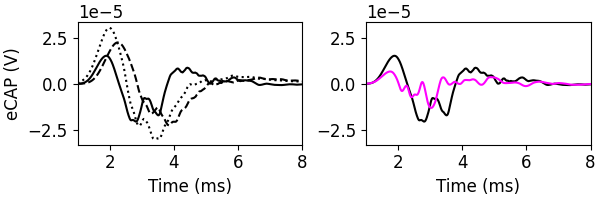

In [28]:
# Plots eCAPs recorded with two different distances between the bipolar contacts (12 mm and 3 mm)
# 6 cm distance between stimulus and recording electrode
### Other parameters unchanged

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(6,2),constrained_layout=True)

gs = GridSpec(1,2,figure=fig)

distanceIdx = 0

legend = ['12 mm','3 mm']


# Loads signals recorded with 3 mm separation between recording electrodes instead of 12 mm
    
outputfolderClose = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_close/'

distanceIdx = 0

maff3mm = np.load(outputfolderClose+'/maff/'+str(distanceIdx)+'/signals.npy')
meff3mm = np.load(outputfolderClose+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff3mm = np.load(outputfolderClose+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff3mm = np.load(outputfolderClose+'/ueff/'+str(distanceIdx)+'/signals.npy') 

total3mm = maff3mm + meff3mm + uaff3mm + ueff3mm

ax0 = fig.add_subplot(gs[0,1])
ax0.ticklabel_format(style='sci',axis='y',scilimits=(0,0))

for i in range(1):

    ax0.plot(time[1:-1]*1e3,signals[-1],c='k')
    
    ax0.plot(time[1:-1]*1e3,total3mm[-1],c='fuchsia')
    
    
ax0.set_xlabel('Time (ms)')

ax0.set_xlim([1,8])

# Plots eCAPs recorded with a monopolar configuration

outputfolderMonopolar = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_monopolar/'

distanceIdx = 0

maffMonopolar = np.load(outputfolderMonopolar+'/maff/'+str(distanceIdx)+'/signals.npy')
meffMonopolar = np.load(outputfolderMonopolar+'/meff/'+str(distanceIdx)+'/signals.npy')
uaffMonopolar = np.load(outputfolderMonopolar+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueffMonopolar = np.load(outputfolderMonopolar+'/ueff/'+str(distanceIdx)+'/signals.npy') 

totalMonopolar = maffMonopolar + meffMonopolar + uaffMonopolar + ueffMonopolar

outputfolderMonopolarFar = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_monopolar_far/'

maffMonopolarFar = np.load(outputfolderMonopolarFar+'/maff/'+str(distanceIdx)+'/signals.npy')
meffMonopolarFar = np.load(outputfolderMonopolarFar+'/meff/'+str(distanceIdx)+'/signals.npy')
uaffMonopolarFar = np.load(outputfolderMonopolarFar+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueffMonopolarFar = np.load(outputfolderMonopolarFar+'/ueff/'+str(distanceIdx)+'/signals.npy') 

totalMonopolarFar = maffMonopolarFar + meffMonopolarFar + uaffMonopolarFar + ueffMonopolarFar


ax7 = fig.add_subplot(gs[0,0],sharey=ax0)
ax7.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
# legend = ['Proximal monopolar','Distal monopolar','Bipolar']
    
ax7.plot(time[1:-1]*1e3,totalMonopolar[-1],':',c='k')
ax7.plot(time[1:-1]*1e3,totalMonopolarFar[-1],'--',c='k')
ax7.plot(time[1:-1]*1e3,signals[-1],c='k')
    
ax7.set_xlabel('Time (ms)')
ax7.set_ylabel('eCAP (V)')
# plt.legend(legend,handlelength=.5)

ax7.set_xlim([1,8])



plt.savefig('figures/recordingfig/recordingfig.png',dpi=600)

## Plots Figure 6 again, but with the legend

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2566689/ipykernel_62706/3677827901.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax0.plot(time[1:-1]*1e3,signals[-1],c='k')
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2566689/ipykernel_62706/3677827901.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax0.plot(time[1:-1]*1e3,total3mm[-1],c='fuchsia')
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2566689/ipykernel_62706/3677827901.py:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax7.plot(time[1:-1]*1e3,totalMonopolar[-1],':',c='k')
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2566689/ipykernel_62706/3677827901.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in th

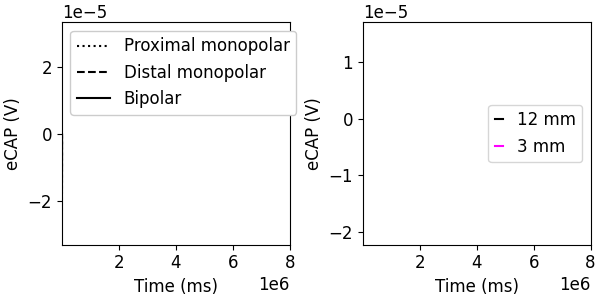

In [45]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(6,3),constrained_layout=True)

gs = GridSpec(1,2,figure=fig)

ax0 = fig.add_subplot(gs[0,1])
ax0.ticklabel_format(style='sci',axis='y',scilimits=(0,0))

for i in range(1):

    ax0.plot(time[1:-1]*1e3,signals[-1],c='k')
    
    ax0.plot(time[1:-1]*1e3,total3mm[-1],c='fuchsia')
    
    
ax0.set_xlabel('Time (ms)')
ax0.set_ylabel('eCAP (V)')
ax0.legend(legend,loc='right',handlelength=.5)
ax0.set_xlim([1,8000000])

ax7 = fig.add_subplot(gs[0,0])
ax7.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
legend = ['Proximal monopolar','Distal monopolar','Bipolar']
    
ax7.plot(time[1:-1]*1e3,totalMonopolar[-1],':',c='k')
ax7.plot(time[1:-1]*1e3,totalMonopolarFar[-1],'--',c='k')
ax7.plot(time[1:-1]*1e3,signals[-1],c='k')
    
ax7.set_xlabel('Time (ms)')
ax7.set_ylabel('eCAP (V)')
plt.legend(legend,framealpha=1)#,handlelength=.5)

ax7.set_xlim([1,8000000])


plt.savefig('figures/recordingfig/recordingfig_legend.png',dpi=600)

# The following several cells produce panels a, c, and e in Figure 7, as well as savaing a numpy file with the rgb values for the fascicles in panels b and d

## Saves numpy file containing percentage of activated myelinated fibers in each fascicle

In [48]:
import matplotlib as mpl

stimList = ['/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic/',
           '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_downward/']


cmap = mpl.cm.ScalarMappable(cmap=mpl.colormaps['viridis'])

fractions = []

for s in stimList:
    for fascIdx in np.arange(39):
        
        recruitment = np.load(s+'/recruitment/recruitment_'+str(fascIdx)+'.npy',allow_pickle=True)[-1][0]
        probs = np.load(s+'/fascicles/probDist'+str(fascIdx)+'.npy',allow_pickle=True)
        pcts = np.load(s+'/fascicles/probs'+str(fascIdx)+'.npy',allow_pickle=True)
        
        maff = probs[0]/(pcts[0]+pcts[1])
        meff = probs[1]/(pcts[0]+pcts[1])

        frac = np.sum(maff*recruitment+meff*recruitment)

        fractions.append(frac)
        
        
rgb = cmap.to_rgba(fractions)

np.save('figures/rgb_percentActivation.npy',rgb)

### Plots a colorbar for the percentage of activated fibers

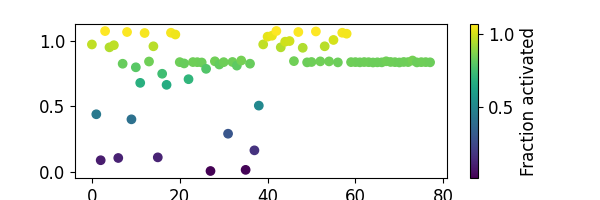

In [49]:
plt.figure(figsize=(6,2))
sc = plt.scatter(np.arange(2*39),fractions,c=fractions)
plt.colorbar(sc,label='Fraction activated')
    
plt.savefig('figures/verticalVhorizontal_colorbar.png',dpi=600)
plt.show()

## Plots Figure 7 a, c, e

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2573552/ipykernel_203689/3589141450.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(6,4.5),constrained_layout=True)
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2573552/ipykernel_203689/3589141450.py:25: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax.plot(time[1:-1]*1e3,totalD[-1],'tab:olive')
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2573552/ipykernel_203689/3589141450.py:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax.plot(time[1:-1]*1e3,signals[-1],'k')
/gpfs/bbp.

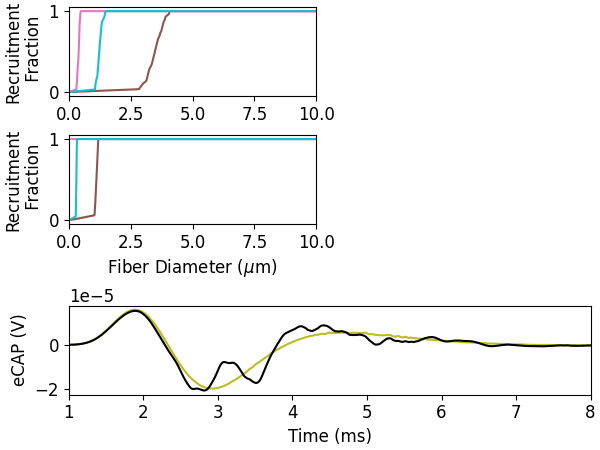

In [50]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(6,4.5),constrained_layout=True)

gs = GridSpec(3,2,figure=fig)

### Loads signals from vertical stimulus electrode

outputfolderD = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_downward/'

distanceIdx = 0

maffD = np.load(outputfolderD+'/maff/'+str(distanceIdx)+'/signals.npy')
meffD = np.load(outputfolderD+'/meff/'+str(distanceIdx)+'/signals.npy')
uaffD = np.load(outputfolderD+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueffD = np.load(outputfolderD+'/ueff/'+str(distanceIdx)+'/signals.npy') 

totalD = maffD + meffD + uaffD + ueffD


ax =  fig.add_subplot(gs[2,:])

for i in range(1):
    
    ax.plot(time[1:-1]*1e3,totalD[-1],'tab:olive')
    ax.plot(time[1:-1]*1e3,signals[-1],'k')
    
ax.set_xlabel('Time (ms)')
ax.set_ylabel('eCAP (V)')
# ax.legend(['Vertical','Horizontal'],loc='right')
ax.set_xlim([1,8])


stimList = ['/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic/',
           '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_downward/']


### For three different fascicles, plots recruitment curves for both electrode orientiations

selectedFasc = [1,20,36]

colors = ['tab:brown','tab:pink','tab:cyan']

for i, stim in enumerate(stimList):
    
    newAx = fig.add_subplot(gs[i,0])
    
    for j, fascIdx in enumerate(selectedFasc):
        recruitment = np.load(stim+'/recruitment/recruitment_'+str(fascIdx)+'.npy',allow_pickle=True)

        newAx.plot(d*1e6,recruitment[-1][0],c=colors[j])

    newAx.set_ylabel('Recruitment\n Fraction')

    if i == 1:
        newAx.set_xlabel('Fiber Diameter ($\mu$m)')

    newAx.set_xlim([0,10])
    
    
plt.savefig('figures/verticalVhorizontal.png',dpi=600)

## Plots legend for Figure 7

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2566689/ipykernel_62706/2782951646.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(6,4.5),constrained_layout=True)
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2566689/ipykernel_62706/2782951646.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax.plot(time[1:-1]*1e3,totalD[-1],'tab:olive')
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2566689/ipykernel_62706/2782951646.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax.plot(time[1:-1]*1e3,signals[-1],'k')


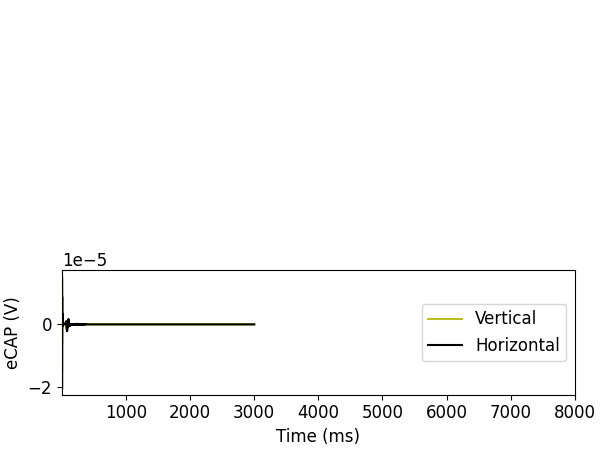

In [49]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(6,4.5),constrained_layout=True)

gs = GridSpec(3,2,figure=fig)


ax =  fig.add_subplot(gs[2,:])

for i in range(1):
    
    ax.plot(time[1:-1]*1e3,totalD[-1],'tab:olive')
    ax.plot(time[1:-1]*1e3,signals[-1],'k')
    
ax.set_xlabel('Time (ms)')
ax.set_ylabel('eCAP (V)')
ax.legend(['Vertical','Horizontal'],loc='right')
ax.set_xlim([1,8000])

    
plt.savefig('figures/verticalVhorizontal_legend.png',dpi=600)

# The following cells plot panels a and b in Figure 8, as well as saving the rgb values of the fascicle colors in panels c-e 

### 6 cm distance between stimulus and recording electrodes
### 12 mm separation between stimulus and recording electrodes
### Signal plotted for 500 uA stimulus current

## Saves sensitivity magnitude for each fascicle as an RGB value

In [51]:
import matplotlib as mpl

CuffList = ['/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/PhiConductivity_Bipolar_Corrected/',
           '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/PhiConductivity_Small_20240213/',
           '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/PhiConductivity_Small_Otherside_20240215/']


cmap = mpl.cm.ScalarMappable(cmap=mpl.colormaps['viridis'])

amps = []

recordingCurrents = [509e-6,250e-6,273e-6]

In [52]:

for i, c in enumerate(CuffList):
    for fascIdx in range(39):
        phi = pd.read_excel(c+str(fascIdx)+'_BetterConductivity.xlsx') 
        amp = np.max(phi.iloc[:,1])-np.min(phi.iloc[:,1])
        amps.append(amp/recordingCurrents[i])
        
rgb = cmap.to_rgba(amps)

np.save('figures/rgb.npy',rgb)


KeyboardInterrupt



### Plots colorbar for the sensitivity magnitudes

In [ ]:
plt.figure(figsize=(6,2))
sc = plt.scatter(np.arange(39*3),amps,c=amps)
plt.colorbar(sc,label='Sensitivity\nAmplitude (V/A)')
plt.savefig('figures/smallCuffAll_colorbar.png',dpi=600)

In [60]:
distanceIdx = 0

outputfolderLeft = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_smallRec/'

maffSmallLeft = np.load(outputfolderLeft+'/maff/'+str(distanceIdx)+'/signals_36.npy')[np.newaxis]
    
meffSmallLeft = np.load(outputfolderLeft+'/meff/'+str(distanceIdx)+'/signals_36.npy')[np.newaxis]

uaffSmallLeft = np.load(outputfolderLeft+'/uaff/'+str(distanceIdx)+'/signals_36.npy')[np.newaxis]

ueffSmallLeft = np.load(outputfolderLeft+'/ueff/'+str(0)+'/signals_36.npy')[np.newaxis]

outputfolderRight = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_smallRec_otherside/'

maffSmallRight = np.load(outputfolderRight+'/maff/'+str(distanceIdx)+'/signals_36.npy')[np.newaxis]
    
meffSmallRight = np.load(outputfolderRight+'/meff/'+str(distanceIdx)+'/signals_36.npy')[np.newaxis]

uaffSmallRight = np.load(outputfolderRight+'/uaff/'+str(distanceIdx)+'/signals_36.npy')[np.newaxis]

ueffSmallRight = np.load(outputfolderRight+'/ueff/'+str(0)+'/signals_36.npy')[np.newaxis]


In [59]:
np.load(outputfolderLeft+'/maff/'+str(distanceIdx)+'/signals.npy').shape

(1, 499997)

## The next cell plots panels a and b in Figure 8

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2573552/ipykernel_203689/92023755.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax.plot(time[1:-1]*1e3,totalSmallLeft[0,-1],c='tab:red')
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2573552/ipykernel_203689/92023755.py:40: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax.plot(time[1:-1]*1e3,totalSmallRight[0,-1],c='tab:purple')
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2573552/ipykernel_203689/92023755.py:41: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax.plot(time[1:-1]*1e3,totalAll[36][-1],c='k')


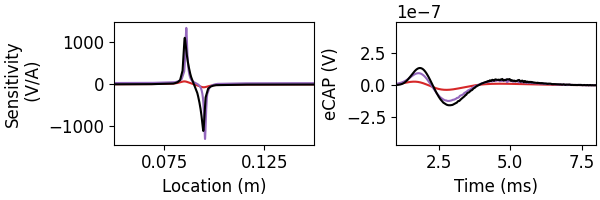

In [62]:
from matplotlib.gridspec import GridSpec

recordingCurrents = [250e-6,273e-6,509e-6]

fig = plt.figure(figsize=(6,2),constrained_layout=True)

gs = GridSpec(1,2,figure=fig)

## Loads signals recorded with the small electrode on the left side of the nerve

# outputfolderLeft = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_smallRec/'

# distanceIdx = 0

# maffSmallLeft = np.load(outputfolderLeft+'/maff/'+str(distanceIdx)+'/signals.npy')
# meffSmallLeft = np.load(outputfolderLeft+'/meff/'+str(distanceIdx)+'/signals.npy')
# uaffSmallLeft = np.load(outputfolderLeft+'/uaff/'+str(distanceIdx)+'/signals.npy')
# ueffSmallLeft = np.load(outputfolderLeft+'/ueff/'+str(distanceIdx)+'/signals.npy') 

totalSmallLeft = maffSmallLeft + meffSmallLeft + uaffSmallLeft + ueffSmallLeft

# ## Loads signals recorded with the small electrode on the right side of the nerve

# outputfolderRight = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_smallRec_otherside/'

# distanceIdx = 0

# maffSmallRight = np.load(outputfolderRight+'/maff/'+str(distanceIdx)+'/signals.npy')
# meffSmallRight = np.load(outputfolderRight+'/meff/'+str(distanceIdx)+'/signals.npy')
# uaffSmallRight = np.load(outputfolderRight+'/uaff/'+str(distanceIdx)+'/signals.npy')
# ueffSmallRight = np.load(outputfolderRight+'/ueff/'+str(distanceIdx)+'/signals.npy') 

totalSmallRight = maffSmallRight + meffSmallRight + uaffSmallRight + ueffSmallRight

ax =  fig.add_subplot(gs[0,1])

for i in range(1):
    
    ax.plot(time[1:-1]*1e3,totalSmallLeft[0,-1],c='tab:red')
    ax.plot(time[1:-1]*1e3,totalSmallRight[0,-1],c='tab:purple')
    ax.plot(time[1:-1]*1e3,totalAll[36][-1],c='k')
    # ax.plot(time[1:-1]*1e3,signals[-1],c='k')
    
ax.set_xlabel('Time (ms)')
ax.set_ylabel('eCAP (V)')
# ax.legend(['Small, left', 'Small, right','Full cuff'],loc='right')
ax.set_xlim([1,8])

### Loads sensitivity functions for selected fasc icles, for each of the three recording electrode configurations

CuffList = ['/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/PhiConductivity_Small_20240213/',
           '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/PhiConductivity_Small_Otherside_20240215/',
           '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/PhiConductivity_Bipolar_Corrected/']



selectedFasc = [1,20,36]

colors = ['tab:red','tab:purple','k']

for i, cuff in enumerate(CuffList):

    if i == 0:
    
        newAx = fig.add_subplot(gs[0,0])
    
    for fascIdx in [selectedFasc[2]]:
        phi = pd.read_excel(cuff+str(fascIdx)+'_BetterConductivity.xlsx') 

        newAx.plot(phi.iloc[:,0], phi.iloc[:,1]/recordingCurrents[i],c=colors[i])

    newAx.set_ylabel('Sensitivity\n (V/A)')

    if i == 2:
        newAx.set_xlabel('Location (m)')

    newAx.set_xlim([0.05,0.15])

newAx.set_xticks([0.075,0.125])
    
    
plt.savefig('figures/smallCuffAll.png',dpi=600)

### Plots the legend for Fig 8

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2562721/ipykernel_267384/416366577.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax.plot(time[1:-1]*1e3,totalSmallLeft[-1],c='tab:red')
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2562721/ipykernel_267384/416366577.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax.plot(time[1:-1]*1e3,totalSmallRight[-1],c='tab:purple')
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2562721/ipykernel_267384/416366577.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax.plot(time[1:-1]*1e3,signals[-1],c='k')


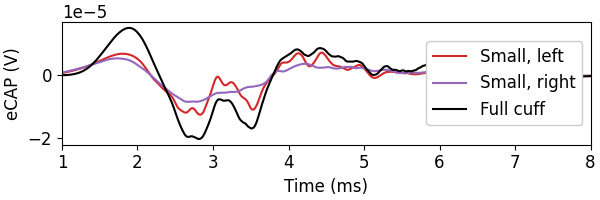

In [55]:
from matplotlib.gridspec import GridSpec

recordingCurrents = [250e-6,273e-6,509e-6]

fig = plt.figure(figsize=(6,2),constrained_layout=True)

gs = GridSpec(1,1,figure=fig)

ax =  fig.add_subplot(gs[0])

for i in range(1):
    
    ax.plot(time[1:-1]*1e3,totalSmallLeft[-1],c='tab:red')
    ax.plot(time[1:-1]*1e3,totalSmallRight[-1],c='tab:purple')
    ax.plot(time[1:-1]*1e3,signals[-1],c='k')
    
ax.set_xlabel('Time (ms)')
ax.set_ylabel('eCAP (V)')
ax.legend(['Small, left', 'Small, right','Full cuff'],loc='right',framealpha=1)
ax.set_xlim([1,8])

plt.savefig('figures/smallCuffAll_legend.png',dpi=600)

# The following cell produces Figure G1, demonstrating the effects of gaussian jitter in recruitment curve
### A random variable is added to the recruitment threshold for each fiber in the S4L model, with mean 10% to 40% of the threshold
### 500 uA stimulus current applied
### 6 cm distance between stimulus and recording electrodes

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2562721/ipykernel_267384/3000482543.py:31: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  axes[i].plot(time[1:-1]*1e3,total6cm[i],c='k')
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2562721/ipykernel_267384/3000482543.py:41: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax4.plot(time[1:-1]*1e3,signals[-1],c='k')


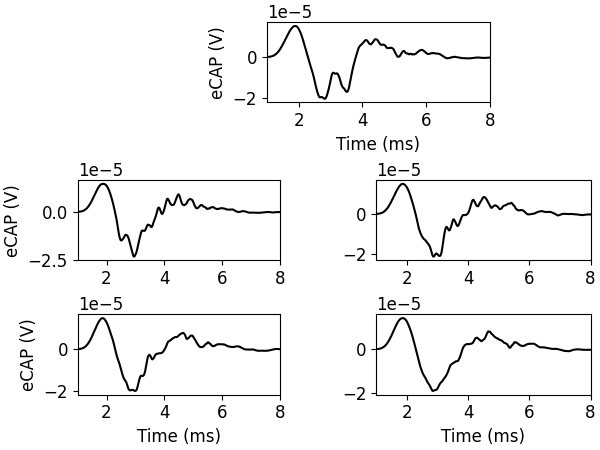

In [56]:
outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_gaussian/'

distanceIdx = 0

maff6cm = np.load(outputfolder+'/maff/'+str(distanceIdx)+'/signals.npy')
meff6cm = np.load(outputfolder+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff6cm = np.load(outputfolder+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff6cm = np.load(outputfolder+'/ueff/'+str(distanceIdx)+'/signals.npy') 

total6cm = maff6cm + meff6cm + uaff6cm + ueff6cm

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(6,4.5),constrained_layout=True)

gs = GridSpec(3,6,figure=fig)
ax0 = fig.add_subplot(gs[1,:3])
ax1 = fig.add_subplot(gs[1,3:])
ax2 = fig.add_subplot(gs[2,:3])
ax3 = fig.add_subplot(gs[2,3:])
ax4 = fig.add_subplot(gs[0,2:5])

axes = [ax0,ax1,ax2,ax3,ax4]

legend = []

jitters = np.linspace(10,40,4)

for i in range(4):

    axes[i].plot(time[1:-1]*1e3,total6cm[i],c='k')
    
    # axes[i].set_title(str(jitters[i]) +'% jitter')
    axes[i].set_xlim([1,8])
    if i%2 == 0:
        axes[i].set_ylabel('eCAP (V)')
    if int(i/2)==1:
        axes[i].set_xlabel('Time (ms)')
    
    
ax4.plot(time[1:-1]*1e3,signals[-1],c='k')

# ax4.set_title('Reference Signal')
    
ax4.set_xlabel('Time (ms)')
ax4.set_ylabel('eCAP (V)')

ax4.set_xlim([1,8])

plt.savefig('figures/gaussian.png',dpi=600)

# The following cell produces Figure H1, demonstrating the effects of increasing the sampling density of the diameters
### 500 uA stimulus current applied
### 6 cm distance between stimulus and recording electrodes

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2562721/ipykernel_267384/1024158237.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(time[1:-1]*1e3,total6cm[-1,:],'g')
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2562721/ipykernel_267384/1024158237.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(time[1:-1]*1e3,signals[-1,:],'k--')


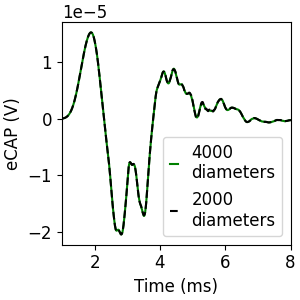

In [57]:
fig = plt.figure(figsize=(3,3),constrained_layout=True)

outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_moreDiameters/'

distanceIdx = 0

maff6cm = np.load(outputfolder+'/maff/'+str(distanceIdx)+'/signals.npy')
meff6cm = np.load(outputfolder+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff6cm = np.load(outputfolder+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff6cm = np.load(outputfolder+'/ueff/'+str(distanceIdx)+'/signals.npy') 

total6cm = maff6cm + meff6cm + uaff6cm + ueff6cm


plt.plot(time[1:-1]*1e3,total6cm[-1,:],'g')
plt.plot(time[1:-1]*1e3,signals[-1,:],'k--')

plt.legend(['4000\ndiameters','2000\ndiameters'],handlelength=0.5)

plt.xlim([1,8])

plt.xlabel('Time (ms)')
plt.ylabel('eCAP (V)')

plt.show()

plt.savefig('figures/samplingDensity.png',dpi=600)

# The following cell produces Figure I1, demonstrating the effects of changing the threshold at which the sensitivity curve is linearized
### 500 uA stimulus current applied
### 6 cm distance between stimulus and recording electrodes

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2562721/ipykernel_267384/3013581991.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(time[1:-1]*1e3,total6cm[-1,:],'g')
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2562721/ipykernel_267384/3013581991.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(time[1:-1]*1e3,signals[-1,:],'k--')


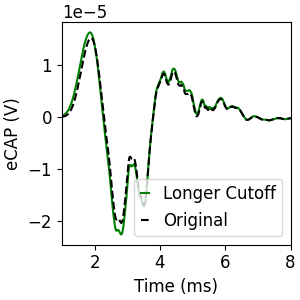

In [58]:
fig = plt.figure(figsize=(3,3),constrained_layout=True)

outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_testCutoff/'

distanceIdx = 0

maff6cm = np.load(outputfolder+'/maff/'+str(distanceIdx)+'/signals.npy')
meff6cm = np.load(outputfolder+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff6cm = np.load(outputfolder+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff6cm = np.load(outputfolder+'/ueff/'+str(distanceIdx)+'/signals.npy') 

total6cm = maff6cm + meff6cm + uaff6cm + ueff6cm


plt.plot(time[1:-1]*1e3,total6cm[-1,:],'g')
plt.plot(time[1:-1]*1e3,signals[-1,:],'k--')

plt.legend(['Longer Cutoff','Original'],handlelength=0.5)

plt.xlim([1,8])

plt.xlabel('Time (ms)')
plt.ylabel('eCAP (V)')

plt.show()

plt.savefig('figures/sensitivityCurve.png',dpi=600)